#  Clean Labels
Clean each label file individually
- Reads dwh tables from `/storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler/dwh_tables`
- Writes cleaned dwh tables to `/storage/groups/ml01/datasets/projects/20181610_eyeclinic_niklas.koehler/dwh_tables_cleaned`

In [3]:
import os
import pandas as pd
from ipywidgets import interact, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import re
from glob import glob
from datetime import datetime
from pydicom import read_file
from tqdm import tqdm_notebook as tqdm
import imageio

import sys
sys.path.append('../../DeepRT/thickness_map_calculation')
import dicom_table as dt

In [55]:
#TODO 7.1. change to dwh_tables folder when cleanup is complete
data_dir = '/storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler/dwh_tables_new'
clean_data_dir = '/storage/groups/ml01/datasets/projects/20181610_eyeclinic_niklas.koehler/dwh_tables_cleaned'

thickness_base_path = '/storage/groups/ml01/datasets/projects/20181610_eyeclinic_niklas.koehler/thickness_map_data'


## Clean visus labels

In [5]:
def to_logMAR(va):
    # converts decimal va values to logMAR scale
    try:
        va = float(va)
        if va == 0:
            return np.inf
        else:
            return np.log10(1/va)
    except ValueError:
        return np.nan

def get_visual_acuity(group):
    # parses items in ordered group. If first value cannot be parsed, moves on to next value
    for i, raw in enumerate(list(group.visual_acuity_raw)):
        va = parse_visual_acuity(raw)
        if va is not None:
            res = list(group.iloc[i])
            res.append(va)
            return res
    return None

def parse_visual_acuity(raw):
    if pd.isna(raw):
        return None
    
    # match range of two comma/dot separated values
    m = re.match(r'.*(\d+)[,\.](\d+)[ -]+(\d+)[,\.](\d+).*$', raw)
    if m:
        return np.mean([float('{}.{}'.format(m.group(1), m.group(2))), 
                       float('{}.{}'.format(m.group(3), m.group(4)))])
    
    # match comma/dot separated value, allowing comma, space, "sc" as first character
    m = re.match(r'[ ,\.a-zA-Z]*([\do]+)[\., ]+(\d+).*$', raw)
    if m:
        return float('{}.{}'.format(m.group(1).replace('o', '0'), m.group(2)))
    
    # match two integer values separated with /, allowing space, "sc, HT" as first character
    m = re.match(r'[ a-zA-Z:]*(\d+)[ /]+(\d+)[a-zA-Z \.]*$', raw)
    if m:
        return int(m.group(1))/float(m.group(2))
        
    # match HBW
    if re.match(r'.*[hH]\.*[bB]\.*[wW]*\.*', raw):
        return 'HBW'
    # match FZ
    if re.match(r'[fF]\.*[zZ]\.*', raw):
        return 'FZ'
    # match Lilo
    if re.match(r'li(cht){0,1}(lo(kal){0,1}){0,1}', raw, flags=re.IGNORECASE):
        return 'LILO'
    # match Nulla LUX
    if re.match(r'(n[ulla]*|kein)\.* *l([ux\.]*|[icht]*)', raw, flags=re.IGNORECASE):        
        return 'NL'
    # match FIX
    if re.match(r'fix.*', raw, flags=re.IGNORECASE):
        return 'FIX'
    # match LUX
    if re.match(r'.*lux.*', raw, flags=re.IGNORECASE):  
        return 'LUX'
    return None

In [6]:
visus_labels = pd.read_csv(os.path.join(data_dir, 'visus_labels.csv'), index_col=0)
print('Starting with {} measurements'.format(len(visus_labels)))

# rename columns
visus_labels.rename(columns={'AUGE': 'laterality_raw', 'MEASUREMENT_DATE':'study_date', 'PATNR':'patient_id',
                            'visual_acuity_VISUS': 'visual_acuity_raw', 'ORIGIN_TYPE': 'visual_acuity_origin'}, inplace=True)
# format columns 
visus_labels.study_date = pd.to_datetime(visus_labels.study_date)
visus_labels.visual_acuity_origin = pd.Categorical(visus_labels.visual_acuity_origin,
                                                   ['SR', 'OR', 'CC', 'STP', 'SC'])

# duplicate entries for laterality=='B'
visus_labels['laterality'] = visus_labels['laterality_raw']
visus_labels.loc[visus_labels['laterality_raw'] == 'B', 'laterality'] = 'L'
visus_R = visus_labels.loc[visus_labels['laterality_raw'] == 'B'].copy().assign(laterality='R')
visus_labels = visus_labels.append(visus_R, ignore_index=True)

# get rid of exact duplicates
num_raw = visus_labels.shape[0]
visus_labels = visus_labels.drop_duplicates(keep='first')
num_raw_nodup = visus_labels.shape[0]
print('Dropped {} exact duplicates'.format(num_raw-num_raw_nodup))

# take care of duplicate measurements per time point
num_dups = sum(visus_labels.duplicated(['study_date', 'patient_id', 'laterality']))
print('Resolving {} duplicate measurements per time point'.format(num_dups))

# group by duplicate measurements
groups = visus_labels.groupby(['patient_id', 'laterality', 'study_date'])
keys = groups.groups.keys()

Starting with 843608 measurements
Dropped 24139 exact duplicates
Resolving 199177 duplicate measurements per time point


In [7]:
print('Before visual acuity parsing: {} unique time/patient/laterality measurements'.format(len(keys)))

rows = []
for key in tqdm(keys):
    # sort values to ensure that correct VA value is taken 
    grp = groups.get_group(key).sort_values('visual_acuity_origin')
    res = get_visual_acuity(grp)
    if res is not None:
        rows.append(res)
        
visus_labels_clean = pd.DataFrame.from_records(rows, columns=['patient_id', 'visual_acuity_raw', 'laterality_raw', 'study_date', 'visual_acuity_origin', 'laterality', 'visual_acuity'])
print('Number of cleaned measurements {}'.format(visus_labels_clean.shape[0]))

Before visual acuity parsing: 620829 unique time/patient/laterality measurements



Number of cleaned measurements 618989


In [8]:
# add logMAR_raw column (unmapped, no string values)
visus_labels_clean['logMAR_raw'] = visus_labels_clean.visual_acuity.apply(to_logMAR)

In [14]:
va_num = visus_labels_clean['logMAR_raw']
va_str = visus_labels_clean['visual_acuity_raw']

# print frequency of logMAR values and strings
nums, bins = np.histogram(va_num, bins=np.concatenate([[-np.inf], np.arange(-0.4,2.1,0.2), [10, np.inf]]))
for i, num in enumerate(nums[:-1]):
    print('[{:.1f},{:.1f}):\t{}'.format(bins[i], bins[i+1], nums[i]))
print('[{:.1f},{:.1f}]:\t{}'.format(bins[-2], bins[-1], nums[-1]))

for s in ['FZ', 'HBW', 'FIX', 'LILO', 'LUX', 'NL']:
    print('{}:\t\t{}'.format(s, sum(va_str==s)))

[-inf,-0.4):	7
[-0.4,-0.2):	805
[-0.2,0.0):	13335
[0.0,0.2):	265585
[0.2,0.4):	175052
[0.4,0.6):	26873
[0.6,0.8):	39794
[0.8,1.0):	5582
[1.0,1.2):	26546
[1.2,1.4):	15527
[1.4,1.6):	7626
[1.6,1.8):	3016
[1.8,2.0):	367
[2.0,10.0):	54
[10.0,inf]:	17
FZ:		6317
HBW:		16613
FIX:		1071
LILO:		6
LUX:		2388
NL:		2933


map logMAR and string values:
- logMAR < -0.3 gets mapped to -0.3
- logMAR == inf gets mapped to value for NL (va 0 means blind!)
- logMAR > 2.0 gets mapped to 2.0
- FZ (count fingers) gets mapped to 2.2
- HBW gets mapped to 2.4
- FIX/LILO gets mapped to 2.6
- LUX gets mapped to 2.8
- NL gets mapped to 3.0

In [15]:
visus_labels_clean['logMAR'] = visus_labels_clean.logMAR_raw
# mapping logMAR values
visus_labels_clean.loc[visus_labels_clean.logMAR_raw<-0.3, 'logMAR'] = -0.3
visus_labels_clean.loc[visus_labels_clean.logMAR_raw>2.0, 'logMAR'] = 2.0
visus_labels_clean.loc[visus_labels_clean.logMAR_raw==np.inf, 'logMAR'] = 3.0
# string values
visus_labels_clean.loc[visus_labels_clean.visual_acuity=='FZ', 'logMAR'] = 2.2
visus_labels_clean.loc[visus_labels_clean.visual_acuity=='HBW', 'logMAR'] = 2.4
visus_labels_clean.loc[visus_labels_clean.visual_acuity=='FIX', 'logMAR'] = 2.6
visus_labels_clean.loc[visus_labels_clean.visual_acuity=='LILO', 'logMAR'] = 2.6
visus_labels_clean.loc[visus_labels_clean.visual_acuity=='LUX', 'logMAR'] = 2.8
visus_labels_clean.loc[visus_labels_clean.visual_acuity=='NL', 'logMAR'] = 3.0

In [16]:
# print frequency of logMAR values and strings
nums, bins = np.histogram(visus_labels_clean.logMAR, bins=np.concatenate([[-np.inf], np.arange(-0.401,3.1,0.2), [np.inf]]))
for i, num in enumerate(nums[:-1]):
    print('[{:.3f},{:.3f}):\t{}'.format(bins[i], bins[i+1], nums[i]))
print('[{:.3f},{:.3f}]:\t{}'.format(bins[-2], bins[-1], nums[-1]))


[-inf,-0.401):	0
[-0.401,-0.201):	812
[-0.201,-0.001):	13335
[-0.001,0.199):	265585
[0.199,0.399):	175052
[0.399,0.599):	26873
[0.599,0.799):	39794
[0.799,0.999):	5582
[0.999,1.199):	26546
[1.199,1.399):	15527
[1.399,1.599):	7626
[1.599,1.799):	3016
[1.799,1.999):	331
[1.999,2.199):	90
[2.199,2.399):	6418
[2.399,2.599):	18480
[2.599,2.799):	4135
[2.799,2.999):	4665
[2.999,inf]:	5122


In [17]:
# save cleaned table
visus_labels_clean.to_csv(os.path.join(clean_data_dir, 'visus_labels_clean.csv'))

## Diagnoses

In [18]:
diagnosis = pd.read_csv(os.path.join(data_dir, 'diagnosis.csv'), index_col=0)
print('Starting with {} measurements'.format(len(diagnosis)))

# rename columns
diagnosis.rename(columns={'LOK': 'laterality_raw', 'DAT':'study_date', 'PATNR':'patient_id', 'DKAT':'DKAT', 'DKEY':'diagnosis'}, inplace=True)
# format columns 
diagnosis.study_date = pd.to_datetime(diagnosis.study_date)
diagnosis.diagnosis = diagnosis.diagnosis.astype('str')
# remove non-eye related diagnoses
diagnosis['category'] = diagnosis.diagnosis.apply(lambda x: x[0])
diagnosis = diagnosis[diagnosis.category == 'H']  # TODO need to include 'E' as well for diabetic retinopathy
print('Starting with {} diagnoses of eye diseases'.format(len(diagnosis)))

# removing duplicates
diagnosis = diagnosis.drop_duplicates()
print('After removing duplicates: {} diagnoses'.format(len(diagnosis)))

# todo drop nan laterality diagnoses? 
# put duplicate diagnoses in list

/home/icb/hannah.spitzer/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Starting with 1820324 measurements
Starting with 892118 diagnoses of eye diseases
After removing duplicates: 818650 diagnoses


In [19]:
# load descriptions of diagnoses
diagnosis_code = pd.read_csv(os.path.join(clean_data_dir, 'icd10cm_order_2018.txt'), sep='\t', header=None)

codes = []
desc = []
for i in range(len(diagnosis_code)):
    code = diagnosis_code[0][i]
    codes.append(code[6:14].strip())
    desc.append(code[16:77].strip())
    
diagnosis_code['diagnosis'] = codes
diagnosis_code['description'] = desc
diagnosis_code = diagnosis_code[['diagnosis', 'description']]   

In [20]:
# statistics
diag = list(diagnosis['diagnosis'])
diag_cl = []
for d in diag:
    if len(re.findall(r'H\d\d\.\d', d)) > 0:
        diag_cl.append(d)
        
unique, counts = np.unique(diag_cl, return_counts=True)

# sort by frequency
unique_sorted = [x for _,x in sorted(zip(counts,unique), reverse=True)]
counts_sorted = sorted(counts, reverse=True)

In [21]:
for i in range(20):
    desc = diagnosis_code[diagnosis_code.diagnosis==unique_sorted[i].replace('.','')].description
    try:
        desc = desc.iloc[0]
    except IndexError:
        desc = ''
    print('{}: {}: {}'.format(counts_sorted[i], unique_sorted[i], desc))
    

80700: H35.3: Degeneration of macula and posterior pole
28009: H33.0: Retinal detachment with retinal break
26062: H25.8: Other age-related cataract
25241: H40.1: Open-angle glaucoma
22187: H35.8: Other specified retinal disorders
20276: H52.1: Myopia
18298: H25.1: Age-related nuclear cataract
17109: H52.0: Hypermetropia
16506: H34.8: Other retinal vascular occlusions
15888: H00.0: Hordeolum (externum) (internum) of eyelid
15794: H16.0: Corneal ulcer
15221: H26.9: Unspecified cataract
14285: H50.0: Esotropia
12024: H16.1: Other and unsp superficial keratitis without conjunctivitis
11883: H52.2: Astigmatism
10851: H04.1: Other disorders of lacrimal gland
10809: H10.0: Mucopurulent conjunctivitis
10601: H36.0: 
10226: H43.1: Vitreous hemorrhage
10047: H47.2: Optic atrophy


(0, 200)

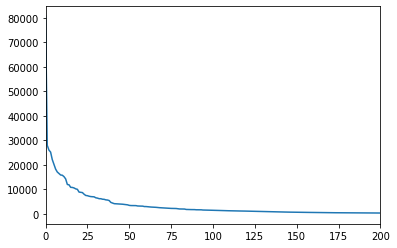

In [22]:
plt.plot(range(len(counts_sorted)), [int(u) for u in counts_sorted])
plt.xlim(0,200)

## Process new confirmed diagnoses from Karsten

In [31]:
diagnosis_left = pd.read_csv(os.path.join(data_dir, 'longitudinal_patients_left_eye.csv'), index_col=0)
diagnosis_right = pd.read_csv(os.path.join(data_dir, 'longitudinal_patients_right_eye.csv'), index_col=0)
diagnosis = diagnosis_left.append(diagnosis_right, ignore_index=True)
print('Starting with {} measurements'.format(len(diagnosis)))

# rename columns
diagnosis.rename(columns={'EYE': 'laterality_raw', 'Karsten':'diagnosis_raw', 'pseudo_id':'patient_id', 'IOL':'iol_date'}, inplace=True)
# format columns 
diagnosis.iol_date = pd.to_datetime(diagnosis.iol_date)
diagnosis.diagnosis_raw.loc[diagnosis.diagnosis_raw.isna()] = diagnosis.DIAGNOSE1.loc[diagnosis.diagnosis_raw.isna()]
diagnosis['laterality'] = diagnosis.laterality_raw.str.upper()
# add diagnosis column (only containing AMD and DR diagnosis for now)
diagnosis['diagnosis'] = np.nan
diagnosis.diagnosis.loc[diagnosis.diagnosis_raw.apply(lambda x: 'AMD' in x)] = 'AMD'
diagnosis.diagnosis.loc[diagnosis.diagnosis_raw.apply(lambda x: 'Diabetisches' in x)] = 'DR'

#diagnosis.diagnosis = diagnosis.diagnosis.astype('str')

print('Have {} longitudinal eyes, {} of which have diagnosis AMD, and {} have DR'.format(
    len(diagnosis), 
    (diagnosis.diagnosis == 'AMD').sum(), 
    (diagnosis.diagnosis == 'DR').sum()))


Starting with 1770 measurements
Have 1770 longitudinal eyes, 1196 of which have diagnosis AMD, and 248 have DR


In [32]:
# save cleaned table
diagnosis.to_csv(os.path.join(clean_data_dir, 'diagnosis_longitudinal_clean.csv'))

## Injections

In [33]:
medications = pd.read_csv(os.path.join(data_dir, 'medications.csv'), index_col=0)

# rename columns
medications.rename(columns={'AUGE': 'laterality_raw', 'DAT':'study_date', 'PATNR':'patient_id', 'FALNR': 'MED_FALNR'}, inplace=True)
# format columns 
medications.study_date = pd.to_datetime(medications.study_date)

# duplicate entries for laterality=='B'
medications['laterality_raw'].fillna('B', inplace=True)
medications['laterality'] = medications['laterality_raw']
medications.loc[medications['laterality_raw'] == 'B', 'laterality'] = 'L'
medications_R = medications.loc[medications['laterality_raw'] == 'B'].copy().assign(laterality='R')
medications = medications.append(medications_R, ignore_index=True)

# get rid of exact duplicates (excluding FALNR)
num_raw = medications.shape[0]
medications = medications.drop_duplicates(['patient_id', 'study_date', 'MED', 'laterality'], keep='first')
num_raw_nodup = medications.shape[0]
print('Dropped {} exact duplicates'.format(num_raw-num_raw_nodup))

# get rid of NaN MED values
medications = medications.dropna(subset=['MED'])
print('Dropped {} nan MED values'.format(num_raw_nodup-medications.shape[0]))

# remaining: several medications at one time
num_dups = sum(medications.duplicated(['study_date', 'patient_id', 'laterality']))
print('Remaining: {} with 2 or more medications per time point'.format(num_dups))

Dropped 2559 exact duplicates
Dropped 209 nan MED values
Remaining: 38 with 2 or more medications per time point


In [34]:
# save cleaned table - as injections
medications.to_csv(os.path.join(clean_data_dir, 'injections_clean.csv'))
print('Saved {} injections'.format(len(medications)))

Saved 5735 injections


## Other procedures

In [35]:
procedures = pd.read_csv(os.path.join(data_dir, 'prozeduren.csv'), index_col=0)

# rename columns
procedures.rename(columns={'LOK': 'laterality_raw', 'DAT':'study_date', 'PATNR':'patient_id'}, inplace=True)
# format columns 
procedures.study_date = pd.to_datetime(procedures.study_date)

# duplicate entries for laterality=='B'
procedures['laterality_raw'].fillna('B', inplace=True)
procedures['laterality'] = procedures['laterality_raw']
procedures.loc[procedures['laterality_raw'] == 'B', 'laterality'] = 'L'
procedures_R = procedures.loc[procedures['laterality_raw'] == 'B'].copy().assign(laterality='R')
procedures = procedures.append(procedures_R, ignore_index=True)

# get rid of exact duplicates
num_raw = procedures.shape[0]
procedures = procedures.drop_duplicates(keep='first')
num_raw_nodup = procedures.shape[0]
print('Dropped {} exact duplicates'.format(num_raw-num_raw_nodup))

# take care of duplicate measurements per time point
num_dups = sum(procedures.duplicated(['study_date', 'patient_id', 'laterality']))
print('Resolving {} duplicate measurements per time point'.format(num_dups))

# remove everything not in chapter 5 08-16 (surgeries of the eye)
procedures_filtered = procedures[procedures.ICPML.apply(lambda x: x[:4] in ['5-08','5-09','5-10','5-11','5-12','5-13','5-14','5-15','5-16'])]
# reduce code to 3 decimals
procedures_filtered.ICPML = procedures_filtered.loc[:,'ICPML'].apply(lambda x: x[:5])
print('Number of filtered procedures {}'.format(len(procedures_filtered)))

Dropped 88885 exact duplicates
Resolving 650526 duplicate measurements per time point
Number of filtered procedures 278009


/home/icb/hannah.spitzer/miniconda3/envs/lode/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


5-156 61071
5-154 45647
5-144 35915
5-158 30014
5-159 13158
5-155 11505
5-091 6836
5-10K 6130
5-142 4759
5-152 4559
5-139 4349
5-096 3456
5-094 2862
5-093 2859
5-097 2778
5-132 2674
5-125 2187
5-131 2115
5-129 1941
5-112 1885


(0, 50)

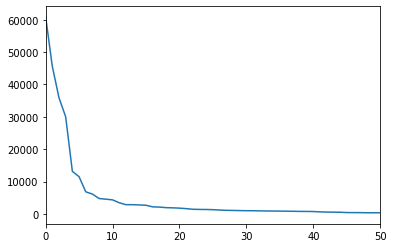

In [36]:
# list most common procedures
unique, counts = np.unique(list(procedures_filtered.ICPML), return_counts=True)
unqiue = [u for _,u in sorted(zip(counts, unique), reverse=True)]
counts = sorted(counts, reverse=True)

for i in range(20):
    print(unqiue[i], counts[i])
    
plt.plot(range(len(counts)), [int(u) for u in counts])
plt.xlim(0,50)

codes with highest occurrence:
- 5-984 nicht relevant
- 5-156.9 - Injektionen
- 5-154 - Netzhautfixierung
- 5-144 - Extrakapsuläre Extraktion der Linse
- 5-158 - Vitrektomie
- 5-985 - Lasertechnik, nicht relevant
- 5-159 - Vitrektomie
- 5-155 - Destruktion von erkranktem Gewebe an Retina und Choroidea
- 5-010 - nicht relevant
- 5-091 - Exzision und Destruktion von (erkranktem) Gewebe des Augenlides, nicht relevant?

In [37]:
# save procedures - not quite clean
procedures_filtered.to_csv(os.path.join(clean_data_dir, 'procedures_clean.csv'))
print('Saved {} procedures'.format(len(procedures_filtered)))

Saved 278009 procedures


## Get OCT and fundus maps
### OCTs

In [38]:
oct_files = pd.read_csv(os.path.join(data_dir, '../oct_paths.csv'), names=['oct_path'])

paths = np.array(oct_files.oct_path)
patient_ids = []
lateralities = []
study_dates = []
oct_paths = []
failures = 0
for p in tqdm(paths):
    try:
        patid = re.match(r'.*Scanner/(\d{1,6})/.*', p).group(1)
        date = re.match(r'.*/(\d{8})/[\d\.]+.*', p).group(1) # excluding Non Standard Format folders here!
        lat = re.match(r'.*(Left|Right).*', p).group(1)
    except AttributeError:
        failures += 1
        continue
    patient_ids.append(int(patid))
    lateralities.append('R' if lat == 'Right' else 'L')
    study_dates.append(datetime.strptime(date, '%Y%m%d'))
    oct_paths.append(p)
    
print('Have {} oct paths ({} could not be parsed)'.format(len(patient_ids), failures))
octs = pd.DataFrame({'patient_id': patient_ids, 'laterality': lateralities, 
                     'study_date': study_dates, 'oct_path': oct_paths})




Have 139208 oct paths (31896 could not be parsed)


### Fundus maps

In [39]:
fundus_files = pd.read_csv(os.path.join(data_dir, '../fundus_paths.csv'), names=['fundus_path'])

paths = np.array(fundus_files.fundus_path)
patient_ids = []
lateralities = []
study_dates = []
fundus_paths = []
failures = 0
for p in tqdm(paths):
    if os.path.splitext(p)[-1] != '.dcm':
        continue
    try:
        patid = re.match(r'.*Ophthalmoscope/(\d{1,6})/.*', p).group(1)
        date = re.match(r'.*/(\d{8})/[\d\.]+.*', p).group(1) # excluding Non Standard Format folders here!
        lat = re.match(r'.*(Left|Right).*', p).group(1)
    except AttributeError:
        failures += 1
        continue
    patient_ids.append(int(patid))
    lateralities.append('R' if lat == 'Right' else 'L')
    study_dates.append(datetime.strptime(date, '%Y%m%d'))
    fundus_paths.append(p)
    
print('Have {} fundus paths ({} could not be parsed)'.format(len(patient_ids), failures))
fundus = pd.DataFrame({'patient_id': patient_ids, 'laterality': lateralities, 
                     'study_date': study_dates, 'fundus_path': fundus_paths})


Have 234187 fundus paths (173 could not be parsed)


### Find matching fundus image for each OCT
1. match by patient_id, laterality, study_date, img_id (from pathname)
2. where this match is not possible, match by aquisition datetime

In [40]:
# get image id for octs and fundus images
octs['img_id'] = octs.oct_path.apply(lambda x: re.findall(r'\.(\d{11}\.\d+)\.', x)[0])
fundus['img_id'] = fundus.fundus_path.apply(lambda x: re.findall(r'\.(\d{11}\.\d+)\.', x)[0])

In [41]:
# match non-duplicates by image id
idx_cols = ['patient_id', 'laterality', 'study_date', 'img_id']
octs_dup_mask = octs.duplicated(idx_cols, keep=False)
octs_nodup = octs[~octs_dup_mask]

fundus_dup_mask = fundus.duplicated(idx_cols, keep=False)
fundus_nodup = fundus[~fundus_dup_mask]

octs_merged_nodup = pd.merge(octs_nodup, fundus_nodup, how='left', on=idx_cols)
num_nomatch = len(octs_merged_nodup[octs_merged_nodup.fundus_path.isna()])
print('Merged {} fundus images to {} octs, resulting in {} matches ({} octs could not be matched)'.format(len(fundus_nodup), len(octs_nodup), len(octs_nodup)-num_nomatch, num_nomatch))

Merged 168352 fundus images to 137299 octs, resulting in 135513 matches (1786 octs could not be matched)


In [42]:
# get not yet matched octs
cols = ['patient_id', 'laterality', 'study_date', 'img_id', 'oct_path']
octs_to_merge = octs_merged_nodup[octs_merged_nodup.fundus_path.isna()][cols]
octs_to_merge = octs_to_merge.append(octs[octs_dup_mask], ignore_index=True)

# potential corresponding fundus images
cols = ['patient_id', 'laterality', 'study_date', 'img_id', 'fundus_path']
fundus_to_merge = pd.merge(octs_to_merge, fundus, how='inner', on=idx_cols)[cols]
fundus_to_merge = fundus_to_merge.drop_duplicates()

print('Identified {} octs and {} fundus images that remain to be matched'.format(len(octs_to_merge), len(fundus_to_merge)))

Identified 3695 octs and 4311 fundus images that remain to be matched


/home/icb/hannah.spitzer/miniconda3/envs/lode/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [43]:
# get acquisition time
print('Getting acquisition time for octs')
oct_dt = []
for p in tqdm(octs_to_merge.oct_path):
    oct_dt.append(read_file(p).AcquisitionDateTime)
octs_to_merge['datetime'] = oct_dt

print('Getting acquisition time for fundus images')
fun_dt = []
for p in tqdm(fundus_to_merge.fundus_path):
    fun_dt.append(read_file(p).AcquisitionDateTime)
fundus_to_merge['datetime'] = fun_dt

Getting acquisition time for octs



Getting acquisition time for fundus images


In [44]:
# merge on shortened datetime
fundus_to_merge['datetime_short'] = fundus_to_merge.datetime.apply(lambda x: x.split('.')[0])
octs_to_merge['datetime_short'] = octs_to_merge.datetime.apply(lambda x: x.split('.')[0])

# only consider non-duplicates
idx_cols = ['patient_id', 'laterality', 'study_date', 'img_id', 'datetime_short']
octs_to_merge_nodup = octs_to_merge[~octs_to_merge.duplicated(idx_cols, keep=False)]
fundus_to_merge_nodup = fundus_to_merge[~fundus_to_merge.duplicated(idx_cols, keep=False)]

# do the merge
octs_merged_datetime = pd.merge(octs_to_merge_nodup, fundus_to_merge_nodup, how='left', on=idx_cols)
num_nomatch = len(octs_merged_datetime[octs_merged_datetime.fundus_path.isna()])
print('Merged {} fundus images to {} octs, resulting in {} matches ({} octs could not be matched)'.format(
    len(fundus_to_merge), len(octs_to_merge), len(octs_merged_datetime)-num_nomatch, num_nomatch))

num_unique_before = len(octs_to_merge[~octs_to_merge.duplicated(['patient_id', 'laterality', 'study_date'])])
num_unique_after = len(octs_merged_datetime[~octs_merged_datetime.fundus_path.isna() & ~octs_merged_datetime.duplicated(['patient_id', 'laterality', 'study_date'])])
print('potential unique OCTs before {} and after {}'.format(num_unique_before, num_unique_after))

Merged 4311 fundus images to 3695 octs, resulting in 1402 matches (2197 octs could not be matched)
potential unique OCTs before 2306 and after 520


In [45]:
# combine merged octs
cols = ['patient_id', 'laterality', 'study_date', 'oct_path', 'fundus_path']
octs_merged = octs_merged_nodup[~octs_merged_nodup.fundus_path.isna()][cols].append(octs_merged_datetime[cols], ignore_index=True)

print('Result of matching fundus to octs: {} matches (of formerly {} octs)'.format(len(octs_merged[~octs_merged.fundus_path.isna()]), len(octs)))

Result of matching fundus to octs: 136915 matches (of formerly 139208 octs)


In [46]:
# save cleaned table
octs_merged.to_csv(os.path.join(clean_data_dir, 'octs_fundus_with_dups.csv'))

### explore OCTs

In [47]:
def show_oct_slice(data_table, slice_no=24):
    plt.figure()
    plt.imshow(data_table.pixel_array[slice_no])
    
def interactive_show_oct_slice(data_table):
    interact(show_oct_slice, 
             slice_no=widgets.IntSlider(min=0, max=48, step=1, value=24), 
             data_table=fixed(data_table))
    
def get_oct_data(d):
    x_starts = []
    y_starts = []
    x_ends = []
    y_ends = []
    for i in range(0, len(d.PerFrameFunctionalGroupsSequence)):    
        y_starts.append(d.PerFrameFunctionalGroupsSequence[i].OphthalmicFrameLocationSequence[0].ReferenceCoordinates[0] )
        x_starts.append(d.PerFrameFunctionalGroupsSequence[i].OphthalmicFrameLocationSequence[0].ReferenceCoordinates[1] )
        y_ends.append(d.PerFrameFunctionalGroupsSequence[i].OphthalmicFrameLocationSequence[0].ReferenceCoordinates[2] )
        x_ends.append(d.PerFrameFunctionalGroupsSequence[i].OphthalmicFrameLocationSequence[0].ReferenceCoordinates[3] )
    return y_starts, x_starts, y_ends, x_ends


#### duplicate OCTs
- some are unreadable, or have the wrong format
- of the duplicates, often one will be of the optical nerve and the other of the macula

In [48]:
octs_merged_nona = octs_merged.dropna()

idx_cols = ['patient_id', 'laterality', 'study_date']
print('Have {} duplicated octs'.format(sum(octs_merged_nona.duplicated(idx_cols))))

dup_octs = octs_merged_nona[octs_merged_nona.duplicated(idx_cols, keep=False)]
octs_grouped = dup_octs.groupby(idx_cols)
oct_keys = octs_grouped.groups.keys()


Have 5170 duplicated octs


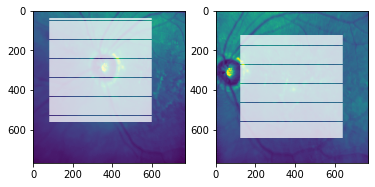

interactive(children=(IntSlider(value=24, description='slice_no', max=48), Output()), _dom_classes=('widget-in…

interactive(children=(IntSlider(value=24, description='slice_no', max=48), Output()), _dom_classes=('widget-in…

In [49]:
# show exemplary octs and fundus images
i=12
cur_octs = octs_grouped.get_group(list(oct_keys)[i])

fig, axes = plt.subplots(1, len(cur_octs))
for i, ax in enumerate(axes):
    f = read_file(cur_octs.iloc[i].fundus_path)
    y_starts, x_starts, y_ends, x_ends = get_oct_data(read_file(cur_octs.iloc[i].oct_path))
    for i in range(len(x_starts)):
        ax.plot([x_starts[i],x_ends[i]],[y_starts[i], y_ends[i]], 'w')
    ax.imshow(f.pixel_array)
for i in range(len(cur_octs)):
    f = read_file(cur_octs.iloc[i].oct_path)
    interactive_show_oct_slice(f)

#### non duplicate OCTs
are they mostly of the macula? or are there also some of the optic nerve?
- seem to be macular octs only
- need to identify macular oct amongst duplicates

In [50]:
nodup_octs = octs_merged_nona.drop_duplicates(idx_cols, keep=False)
print('Have {} non-duplicated octs'.format(len(nodup_octs)))

Have 127279 non-duplicated octs


37366


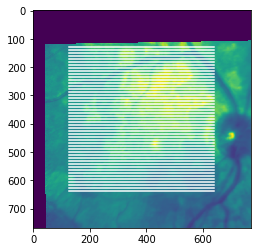

interactive(children=(IntSlider(value=24, description='slice_no', max=48), Output()), _dom_classes=('widget-in…

In [51]:
# show exemplary octs and fundus images
i=np.random.randint(0,len(nodup_octs))
print(i)
cur = nodup_octs.iloc[i]

f = read_file(cur.fundus_path)
d = read_file(cur.oct_path)
y_starts, x_starts, y_ends, x_ends = get_oct_data(d)
for i in range(len(x_starts)):
    plt.plot([x_starts[i],x_ends[i]],[y_starts[i], y_ends[i]], 'w')
plt.imshow(f.pixel_array)
plt.show()
interactive_show_oct_slice(d)

### deal with duplicate octs
... by throwing them out
- in the future, might need to come back to this and do sth more advanced

In [57]:
nodup_octs

,patient_id,laterality,study_date,oct_path,fundus_path
0,363979,R,2018-01-29,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
1,363979,L,2018-01-29,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
2,350569,R,2017-03-06,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
3,350569,L,2017-03-06,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
4,185669,L,2014-12-09,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
...,...,...,...,...,...
139049,96384,L,2015-09-28,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
139052,96384,R,2015-09-28,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
139058,337056,L,2016-04-22,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
139066,320217,L,2017-09-18,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...


In [52]:
# save cleaned table
nodup_octs.to_csv(os.path.join(clean_data_dir, 'octs_fundus_no_dups.csv'))

## Get thickness maps

In [53]:
def display_fundus_thickness(row):
    fig, axes = plt.subplots(1,2)
    axes[0].imsahow(imageio.imread(row.fundus_path))
    axes[1].imshow(np.load(row.thickness_path))

In [56]:
thickness_maps = pd.read_csv(os.path.join(thickness_base_path, 'all_records.csv'), index_col=0, skiprows=1, names=['thickness_path'])

# add full paths to fundus and thickness, and patid, etc 
paths = list(thickness_maps.thickness_path)
thickness_paths = [os.path.join(thickness_base_path, 'thickness_maps', p.replace('.png', '.npy')) for p in paths]

patient_ids = [int(p.split('_')[0]) for p in paths]
lateralities = [p.split('_')[1] for p in paths]
study_dates = [datetime.strptime(p.split('_')[2], '%Y%m%d') for p in paths]

thickness_maps['thickness_path'] = thickness_paths
thickness_maps['patient_id'] = patient_ids
thickness_maps['laterality'] = lateralities
thickness_maps['study_date'] = study_dates
print('Starting with {} thickness maps'.format(len(thickness_maps)))

# drop all duplicates
thickness_maps = thickness_maps.drop_duplicates(['patient_id', 'laterality', 'study_date'], keep=False)
print('Saving {} non-duplicated thickness maps'.format(len(thickness_maps)))
# save cleaned table
thickness_maps.to_csv(os.path.join(clean_data_dir, 'thickness_maps_no_dups.csv'))


Starting with 121985 thickness maps
Saving 114543 non-duplicated thickness maps


# Tensio

- from old notebook, untested
- drop exact duplicates
- take last measurement for duplicate measurements at the same day

In [ ]:
#tensio = pd.read_csv(os.path.join(data_dir, 'dwh_tables/tensio.csv'), index_col=0)

# rename columns
#tensio.rename(columns={'AUGE': 'laterality', 'DAT':'study_date', 'PATNR':'patient_id',
                            'TENSIO': 'tensio'}, inplace=True)
# format columns 
#tensio.study_date = pd.to_datetime(tensio.study_date)
#tensio.tensio = [float(t.replace(',','.')) for t in tensio.tensio]

# get rid of exact duplicates
#num_raw = tensio.shape[0]
#tensio = tensio.drop_duplicates(keep='first')
#num_raw_nodup = tensio.shape[0]
#print('Dropped {} exact duplicates'.format(num_raw-num_raw_nodup))

# take care of duplicate measurements per time point
#num_dups = sum(tensio.duplicated(['study_date', 'patient_id', 'laterality']))
#print('Resolving {} duplicate measurements per time point'.format(num_dups))

#tensio_clean = tensio[~tensio.duplicated(['study_date', 'patient_id', 'laterality'], keep='last')]
#tensio_clean.to_csv(os.path.join(workspace_path, 'tensio_clean.csv'))
#print('Saved {} records to workspace'.format(len(tensio_clean)))